# DIABETES LEARNING



In [ ]:
isGoogleColab = True

# Notes

- check these blog posts: https://muellerzr.github.io/fastblog/ and his course: https://walkwithfastai.com/intro.contribute
- learner.export() already save all the transforms that will be applied during inference time, so it is not necessary to resize or normalize stats. If running outside the model outside fastai, check: https://forums.fast.ai/t/do-we-need-to-normalize-single-image-before-running-predict-function-on-it/44301/4
- to_fp16() is mixed precision
- item_tfms already apply the resize before collating the images in a batch. So it is not necessary to do this manually
- aug_tfms will only be applied on train_dl. validation and test will not be affected
- test_dl is a testing dataloader that uses the same transforms as train_dl and valid_dl, but with new data
- check images cleaner in the future
- cross validation: check walkwithfastai video 3 or https://forums.fast.ai/t/is-it-possible-to-implement-cross-validation-in-fastai/44961/15 or https://forums.fast.ai/t/am-i-doing-k-fold-cross-validation-right/84738/6  
- stratification in Kfold and Train_Test split for Multi Label problems is not straighforward. Check http://scikit.ml/index.html#. Use for now balanced datasets!!!!



# Installation

## Kill all other GPU sessions

Run the first time this cell. Then, restart your session and run again the notebook without this code.

In [ ]:
  #!kill -9 -1

## Keep Session Alive

Put this javascript code in the browser console

In [ ]:
# function ClickConnect(){
#    console.log("Working");
#    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
# }  setInterval(ClickConnect,300000)

## Update ipython/ipykernel (Colab)

The Colab session can fail when running the first time this cell. Just run it a second time.

In [ ]:
# This magic cell should be put first in your colab notebook. 
# It'll automatically upgrade colab's really antique ipython/ipykernel to their 
# latest versions which are required for packages like ipyexperiments 

# from packaging import version
# import IPython, ipykernel
# IPython.__version__
# if version.parse(IPython.__version__) <= version.parse("5.5.0"):
#     !pip install -q --upgrade ipython
#     !pip install -q --upgrade ipykernel
    
#     import os
#     import signal
#     os.kill(os.getpid(), signal.SIGTERM)
# print(f"ipykernel=={ipykernel.__version__}")
# print(f"IPython=={IPython.__version__}")

In [ ]:
# new (large)
# !pip install ipyexperiments
# new (large)
# from ipyexperiments import IPyExperimentsPytorch
# exp = IPyExperimentsPytorch()

## Check GPU e CPU RAM

In [ ]:
if isGoogleColab:
    
    import torch
    from pynvml import *
    nvmlInit()
    def log_mem():
        h = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(h)
        print(f'GPU total Memory    : {info.total}')
        print(f'GPU free Memory     : {info.free}')
        print(f'GPU Memory used     : {info.used}')
    torch.ones(1).to(0)
    log_mem()

    !nvidia-smi

GPU total Memory    : 17071734784
GPU free Memory     : 16116350976
GPU Memory used     : 955383808
Thu Sep  2 18:57:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    33W / 250W |    911MiB / 16280MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------------

## Mount the Google Drive to Google Colab

In [ ]:
if isGoogleColab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path_to_drive = "/content/drive/MyDrive/Colab Notebooks/"
    sys.path.append(path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/') #make src files importable

else:
    path_to_drive = "./"

Mounted at /content/drive


In [ ]:
#!unrar x "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/augmentedDataset_v2.rar" "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/"
#!unrar x "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/augmentedDataset.rar" # extrai local
#!unzip "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/database.zip" -d "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/"

## Install Deep Learning libraries

In [ ]:
!pip install torch==1.9.0
!pip install torchvision==0.10.0
!pip install fastai==2.4.1
!pip install pytorch-lightning
!pip install wandb


# !pip install fastai==2.0.19
# !pip install torchvision==0.7
# !pip install torch==1.6.0
# !pip install fastcore==1.3.2
# !pip install wandb
# !pip install fastprogress==0.2.4

# ##restart runtime!!!

In [ ]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import torchvision; print('Torchvision:',torchvision.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Pytorch: 1.9.0+cu102
Torchvision: 0.10.0+cu102
Fastai: 2.4.1


# Data

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
import torch
import torchvision
from PIL import Image
import wandb
wandb.login()

wandb: Currently logged in as: bunoviske (use `wandb login --relogin` to force relogin)


True

In [ ]:
path = path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/'
path_anno = path + 'gt/'
path_img = path + 'done/'

pathUnimib = path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/' 
pathUnimib_anno = pathUnimib + 'gt/'
pathUnimib_img = pathUnimib + 'done/'


In [ ]:
np.random.seed(2) #mesma semente para todas as vezes que executar
randomSeed = 2

fnames = get_image_files(path_img)
print(fnames[:3])

# fnamesUnimib = get_image_files(pathUnimib_img)
# print(fnamesUnimib[:-3])
# fnames += fnamesUnimib

len(fnames)

[Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/231.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/677.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/526.jpeg')]


469

In [ ]:
codes = np.loadtxt(path + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')
codesId = [code.split(": ")[0] for code in codes]
codes = [code.split(": ")[1] for code in codes] #pega apenas o nome de cada classe e ignora o ID
len(codes)

77

In [ ]:
### fix GT ids: masks must be [0, 1, …, K-1] where K is the number of categories

def get_y_fn(item):
  "Grab a mask from a `filename` and adjust the pixels based on `adjustedGroundTruthIds`"
  if "sprint0" in str(item):
    itemGtPath = path_anno + '/' + f'{item.stem}_GT.png'
  elif "UNIMIB" in str(item):
    itemGtPath = pathUnimib_anno + '/' + f'{item.stem}GT.png'

  msk = np.array(PILMask.create(itemGtPath))
  mx = np.max(msk)
  for i, val in enumerate(adjustedGroundTruthIds):
    msk[msk==adjustedGroundTruthIds[i]] = val
  return PILMask.create(msk)

adjustedGroundTruthIds = dict()
adjustedGroundTruthIds = {i : int(codesId[i]) for i in range(len(codes))}
# createAdjustedGroundTruthIds(label_fnames)

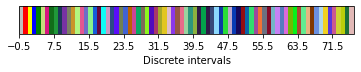

In [ ]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(codes))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) # nao alimento -> cinza
cmaplist[1] = "red" # nao registrado
cmaplist[2] = "yellow" #arroz integral
cmaplist[3] = "blue" #arroz branco
cmaplist[4] = "green" #feijao

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(codes)+1)] # intervalos devem conter apenas o numero inteiro, entao ir de 0.5 em 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

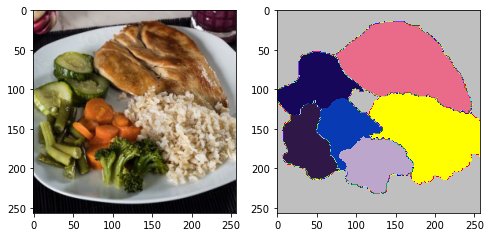

Ground truth Codes [ 0  2 37 43 48 49 50]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/231.jpg


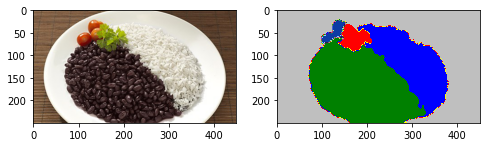

Ground truth Codes [ 0  1  3  4 46]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/677.jpg


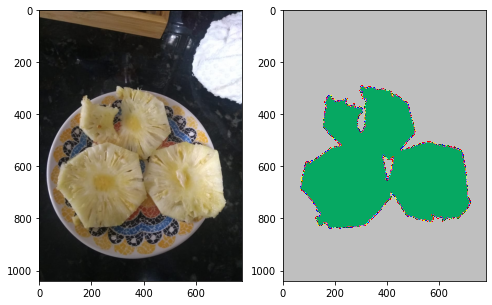

Ground truth Codes [ 0 27]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/526.jpeg


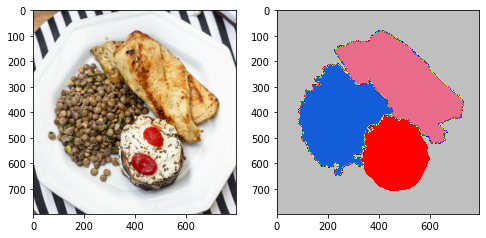

Ground truth Codes [ 0  1 17 37]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/670.jpg


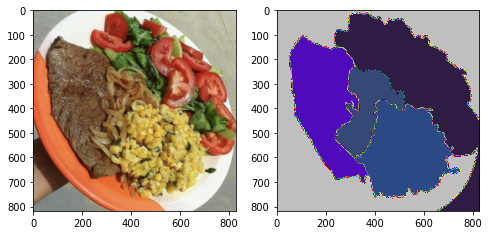

Ground truth Codes [ 0 21 30 41 44]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/132.jpg


In [ ]:
### VISUALIZACAO DA MÁSCARA FICA COM A BORDA ESTRANHA, MAS ELA ESTÁ CORRETA COMO PODE SER VISTO NOS CODIGOS DO GROUND TRUTH

for idx in range(0,5):
  fig = plt.figure(figsize=(8,8))

  img = Image.open(fnames[idx])
  arr = np.asarray(img)
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(arr)

  img1 = get_y_fn(fnames[idx]) # use this when 'adjustedGroundTruthIds' is necessary
  # img1 = Image.open(get_y_fn(fnames[idx]))
  arr = np.asarray(img1)
  ax1 = fig.add_subplot(1,2,2)
  ax1.imshow(arr, cmap=cmap, norm=norm)
  plt.show()

  print("Ground truth Codes", np.unique(arr,return_counts=False))
  print(fnames[idx])


## FASTER RCNN UTILS

In [ ]:
from torchvision import transforms as T
import cv2


def get_prediction(img_path, threshold, codes, model):
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img).to(device)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  pred_class = [codes[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  pred_scores = pred_score[:pred_t+1]
  return pred_boxes, pred_class, pred_scores

def drawPrediction(img, boxes, pred_cls, pred_scores, threshold=0.5, rect_th=1, text_size=0.5, text_th=2):

  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    print(pred_cls[i] + ": " + "{:.2f}%".format(pred_scores[i] * 100))

  plt.figure(figsize=(8,8))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

def object_detection_api(img_path, codes, model, threshold=0.5):
  boxes, pred_cls, pred_scores = get_prediction(img_path, threshold, codes, model)
  
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  drawPrediction(img, boxes, pred_cls, pred_scores, threshold)


# Pytorch Implementation



## FASTER RCNN TEST


Loaded model
dining table: 83.42%
sandwich: 63.74%
sandwich: 58.33%
carrot: 54.10%


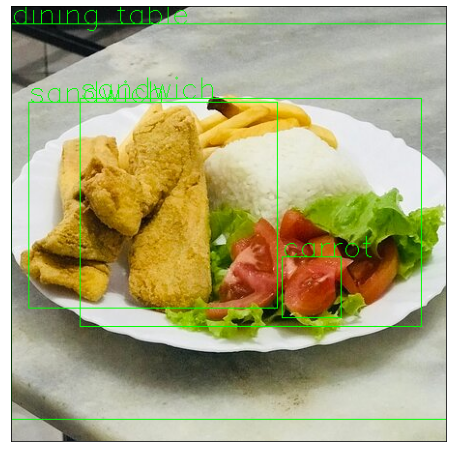

In [ ]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model.to(device)
# model.eval()

# model.transform.min_size = (512,)
# model.transform.max_size = 512
# print("Loaded model")

# COCO_INSTANCE_CATEGORY_NAMES = [
#     '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
#     'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
#     'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
#     'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
#     'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
#     'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
#     'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
#     'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
#     'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
#     'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
#     'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
#     'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
# ]


# object_detection_api(str(fnames[15]), COCO_INSTANCE_CATEGORY_NAMES, model)

## Dataset

In [ ]:
class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, fnames, foodDetectionOnly=False, transforms=None):
        self.fnames = fnames
        self.transforms = transforms
        self.foodDetectionOnly = foodDetectionOnly

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx]).convert("RGB")
        mask = get_y_fn(self.fnames[idx]) # use this when 'adjustedGroundTruthIds' is necessary
        mask = np.array(mask)

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        if self.foodDetectionOnly:
          # there is only one class for food detection
          labels = torch.ones((num_objs,), dtype=torch.int64)
        else:
          labels = torch.as_tensor(obj_ids, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["masks"] = masks


        ###### IGNORE THIS: it is necessary to be compatible with COCO dataset and torchvision engine
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        ######

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.fnames)


In [ ]:
isFoodDetectionOnly = False
testing = FoodDataset(fnames, foodDetectionOnly=isFoodDetectionOnly)

# Food detection or Multi Label Classification?
if isFoodDetectionOnly: 
  codes = [codes[0],"Food"]

In [ ]:
idx = 0

for idx in range(0,10):
  img, label = testing[idx]
  img = np.asarray(img)
  boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(label['boxes'].detach().numpy())]
  labels = [codes[id] for id in (label["labels"])]
  drawPrediction(img, boxes,labels, [1]*len(boxes))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# get data split from files or function

#### split train/test randomly ####
#from sklearn.model_selection import train_test_split
#X_train, X_test, _, _ = train_test_split(fnames, label_fnames, test_size=0.2, random_state=randomSeed, shuffle=True, stratify=None)

#### split by validation.txt ####
# testFiles = np.loadtxt(path + 'validation.txt', dtype=str, delimiter='\n',encoding='utf')
# X_test = [file for file in fnames if file.name in testFiles]

#### split by filenames array from pickle ####
import pickle
with open(path + "testFilenames.pkl", 'rb') as f:
  testFiles = pickle.load(f)
X_test = [file for file in fnames if file.name in testFiles]
X_train = [file for file in fnames if file.name not in testFiles]

len(X_train), len(X_test)

(362, 107)

## Data Augmentation

In [ ]:
import torch
import torchvision

from torch import nn, Tensor
import torchvision.transforms.functional as F
import torchvision.transforms as T

class RandomPhotometricDistort(nn.Module):
    def __init__(self, contrast = (0.5, 1.5), saturation = (0.5, 1.5),
                 hue = (-0.05, 0.05), brightness = (0.875, 1.125), p = 0.5):
        super().__init__()
        self._brightness = T.ColorJitter(brightness=brightness)
        self._contrast = T.ColorJitter(contrast=contrast)
        self._hue = T.ColorJitter(hue=hue)
        self._saturation = T.ColorJitter(saturation=saturation)
        self.p = p

    def forward(self, image,
                target = None):
        if isinstance(image, torch.Tensor):
            if image.ndimension() not in {2, 3}:
                raise ValueError('image should be 2/3 dimensional. Got {} dimensions.'.format(image.ndimension()))
            elif image.ndimension() == 2:
                image = image.unsqueeze(0)

        r = torch.rand(7)

        if r[0] < self.p:
            image = self._brightness(image)

        contrast_before = r[1] < 0.5
        if contrast_before:
            if r[2] < self.p:
                image = self._contrast(image)

        if r[3] < self.p:
            image = self._saturation(image)

        if r[4] < self.p:
            image = self._hue(image)

        if not contrast_before:
            if r[5] < self.p:
                image = self._contrast(image)

        if r[6] < self.p:
            channels = F.get_image_num_channels(image)
            permutation = torch.randperm(channels)

            is_pil = F._is_pil_image(image)
            if is_pil:
                image = F.to_tensor(image)
            image = image[..., permutation, :, :]
            if is_pil:
                image = F.to_pil_image(image)

        return image, target

class RandomHorizontalFlip(T.RandomHorizontalFlip):
    def forward(self, image,target):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                width, _ = F._get_image_size(image)
                target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
                if "masks" in target:
                    target["masks"] = target["masks"].flip(-1)
                if "keypoints" in target:
                    keypoints = target["keypoints"]
                    keypoints = _flip_coco_person_keypoints(keypoints, width)
                    target["keypoints"] = keypoints
        return image, target

class ToTensor(nn.Module):
    def forward(self, image,target):
        image = F.to_tensor(image)
        return image, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
        # transforms.append(RandomPhotometricDistort())
    return Compose(transforms)

## Dataloaders

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

bs = 4 # batch size

trainset = FoodDataset(X_train, foodDetectionOnly=isFoodDetectionOnly, transforms=get_transform(train=True))
trainDataloader = torch.utils.data.DataLoader(
 trainset, batch_size=bs, shuffle=True, num_workers=4,
 collate_fn=collate_fn)

testset = FoodDataset(X_test, foodDetectionOnly=isFoodDetectionOnly, transforms=get_transform(train=False))
testDataloader = torch.utils.data.DataLoader(
 testset, batch_size=bs, shuffle=False, num_workers=4,
 collate_fn=collate_fn)

## Model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_object_detection(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
#### freeze only backbone

def freezeBackboneLayer(model):
  for param in model.backbone.parameters():
    param.requires_grad=False

  for param in model.rpn.parameters():
    param.requires_grad=True
  for param in model.roi_heads.parameters():
    param.requires_grad=True

def unfreezeBackboneLayer(model):
  for param in model.backbone.parameters():
    param.requires_grad=True

  for param in model.rpn.parameters():
    param.requires_grad=True
  for param in model.roi_heads.parameters():
    param.requires_grad=True

In [ ]:
# test model inputs and outputs

# images,targets = next(iter(trainDataloader))
# # images = list(image for image in images)
# # targets = [{k: v for k, v in t.items()} for t in targets]

# model = get_model_instance_segmentation(len(codes))
# output = model(images,targets)   # Returns losses and detections
# print(output)

# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions
# print(predictions[0])

## Use Pytorch Lightning to train

In [ ]:
import torch
from typing import List, Tuple
from torch import nn
from pytorch_lightning.core.lightning import LightningModule

class MaskRCNN(LightningModule):

    def __init__(self, lr=None, weight_decay=None,freezeBackbone=True):
        super().__init__()

        self.modelMaskrcnn = get_model_instance_segmentation(num_classes=len(codes))
        self.modelMaskrcnn.transform.min_size = (256,)
        self.modelMaskrcnn.transform.max_size = 256
        if freezeBackbone:
          freezeBackboneLayer(self.modelMaskrcnn)

        # hparams
        self.lr = lr if lr is not None else 0.01
        self.weight_decay = weight_decay if weight_decay is not None else 0.1

        # metrics
        # self.metricsMethods = BaseMetrics(codes, [])
        # self.modelMetrics = {'accuracy': self.metricsMethods.getAccuracy, 'f1score': self.metricsMethods.get_f1Score}

    def forward(self, input, target=None):
        if target is not None:
          return self.modelMaskrcnn(input, target) #train mode
        else: 
          return self.modelMaskrcnn(input) #eval mode
    
    def configure_optimizers(self):
        params = [p for p in self.parameters() if p.requires_grad]
        optim = torch.optim.AdamW(params, lr=self.lr, weight_decay=self.weight_decay)
        return optim

    
    def training_step(self, batch, batch_idx):
        x, y = batch
        loss_dict = self(x, y)
        loss = sum(loss for loss in loss_dict.values())
        
        metrics = {}
        metrics["loss"] = loss
        self.log_dict(metrics, on_step=True, on_epoch=True)

        return metrics

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
               
        # metrics = self._calculateMetrics(preds, y, phase="val")
        metrics = {}
        metrics["val_loss"] = 0.0
        self.log_dict(metrics)  

        return metrics

    # def validation_epoch_end(self, outputs):
    #     metricsAvg = {}
    #     for key in outputs[0].keys():
    #         metricsAvg[key] = torch.stack([x[key].float() for x in outputs]).mean()

    #     print("validation_epoch_end", metricsAvg)
    #     return metricsAvg

    # def test_step(self, batch, batch_idx):
    #     x, y = batch
    #     preds = self(x)
        
    #     # metrics = self._calculateMetrics(preds, y, phase="test")
    #     metrics["predictions"] = preds
    #     metrics["labels"] = y
    #     self.log_dict(metrics, on_step=False, on_epoch=False, logger=False, prog_bar=False)
  
    #     return metrics

    # def test_epoch_end(self, outputs):
    #     # flatten all predictions and labels! this will be slightly different from torchLightning metrics
    #     predictions = torch.tensor([])
    #     labels = torch.tensor([])
    #     for output in outputs:
    #         predictions = torch.cat((predictions, output['predictions']), 0)
    #         labels = torch.cat((labels, output['labels']), 0)

    #     bestProbabilities, bestPredictions  = self._getBestPredictions(predictions)
    #     labels = labels.cpu()

    #     # calculate metrics and classificationReport with flatten predictions and labels
    #     classificationReport = self.metricsMethods.getClassificationReport(bestPredictions, labels)
    #     metricsFlattenSklearn = self._calculateMetrics(predictions, labels, phase="test")
        
    #     # normal torchLightning average 
    #     metricsAvg = {}
    #     for key in outputs[0].keys():
    #         if key != "predictions" and key != "labels":
    #             metricsAvg[key] = torch.stack([x[key].float() for x in outputs]).mean()
        

    #     # classificationReport has slightly different results from metricsAvg because it flattens all inputs. MetricsAvg is the mean to each batch
    #     print(classificationReport)
    #     print("torch lightning avg metrics", metricsAvg)
    #     print("sklearn flatten metrics", metricsFlattenSklearn)

    #     return metricsAvg


    def _calculateMetrics(self, predictions, labels, phase):
        metrics = {}

        bestProbabilities, bestPredictions  = self._getBestPredictions(predictions)
        for metricName, functionToCall in self.modelMetrics.items():
            metricValue = torch.tensor(functionToCall(bestPredictions, labels.cpu()))
            metrics[phase + '_' + metricName] = metricValue
        
        return metrics

    def _getBestPredictions(self, predictions: torch.Tensor) -> Tuple[np.ndarray,np.ndarray]:
        probabilities = torch.softmax(predictions, 1)
        bestProbabilities, bestPredictions = torch.max(probabilities, 1)
        bestProbabilities = bestProbabilities.detach().cpu().numpy()
        bestPredictions = bestPredictions.detach().cpu().numpy()

        return bestProbabilities, bestPredictions 




In [ ]:
lr = 1e-4
wd = 1e-2
model = MaskRCNN(lr=lr, weight_decay=wd, freezeBackbone=True)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efe94b68200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, QuantizationAwareTraining
from pytorch_lightning.loggers import WandbLogger
import wandb

wandb_logger = WandbLogger(project="diabetesLearning-instanceSegmentation", log_model=False)
wandb_logger.watch(model, log='all', log_freq=100)
#wandb_logger.log_hyperparams(hparams)

# monitored metric is different from val_epoch_end. Maybe because torch lightning applies weighted average on each batch (like they do for the loss) https://forums.pytorchlightning.ai/t/understanding-different-values-of-training-validation-loss-in-callback-metrics-dictionary/568
checkpoint_callback = ModelCheckpoint(monitor='loss', mode="min", verbose=True)
# early_stop_callback = EarlyStopping(monitor='val_loss', mode="min", patience=50, verbose=True)

gpus = 1
epochs = 20
grad_accumulation_batches = int(32/bs) # 32 is the final "batch size"

trainer = Trainer(gpus=gpus,
            max_epochs=epochs, 
            accumulate_grad_batches=grad_accumulation_batches,
            # gradient_clip_val=1.0,
            # amp_backend='apex',
            # amp_level='02',
            precision=32,
            auto_lr_find=False,
            logger=wandb_logger,
            checkpoint_callback=True,
            callbacks=[early_stop_callback, checkpoint_callback])


NameError: ignored

In [ ]:
trainer.fit(model, trainDataloader, testDataloader)
wandb.save(checkpoint_callback.best_model_path)
modelBest = MaskRCNN.load_from_checkpoint(checkpoint_path=checkpoint_callback.best_model_path)
torch.save(modelBest.state_dict(), path + "models/maskrcnn.pt")
print(checkpoint_callback.best_model_path)

### Validate

In [ ]:
# validate

model.load_state_dict(torch.load(path + "maskrcnn.pt"))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.eval()
idx = 0
for idx in range(50,60):
  instance_segmentation_api(str(X_test[idx]),codes, model, threshold=0.95)

## Use torchvision engine to train

In [ ]:
sys.path.append(path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/torchvisionReferences/detection') #make src files importable
from torchvisionReferences.detection.engine import train_one_epoch, evaluate

In [ ]:
modelFasterrcnn = get_model_object_detection(num_classes=len(codes))
modelFasterrcnn.transform.min_size = (256,)
modelFasterrcnn.transform.max_size = 256

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
modelFasterrcnn.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(256,), max_size=256, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(i

In [ ]:
# construct an optimizer

# freezeBackboneLayer(modelFasterrcnn)
unfreezeBackboneLayer(modelFasterrcnn)
params = [p for p in modelFasterrcnn.parameters() if p.requires_grad]

lr = 0.001
wd = 0.0005
num_epochs = 20

optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=wd)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                 step_size=3,
#                                                 gamma=0.1)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                 steps_per_epoch=len(trainDataloader), epochs=num_epochs,
                                                 cycle_momentum=True)


In [ ]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(modelFasterrcnn, optimizer, trainDataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    results = evaluate(modelFasterrcnn, testDataloader, device=device)

    print("Evaluation results")
    print(results)

torch.save(modelFasterrcnn.state_dict(), path + "fasterrcnnTorchvisionTraining.pt")

Epoch: [0]  [ 0/91]  eta: 0:02:40  lr: 0.000000  loss: 0.4725 (0.4725)  loss_classifier: 0.1893 (0.1893)  loss_box_reg: 0.2644 (0.2644)  loss_objectness: 0.0084 (0.0084)  loss_rpn_box_reg: 0.0105 (0.0105)  time: 1.7647  data: 0.4844  max mem: 9477
Epoch: [0]  [10/91]  eta: 0:00:27  lr: 0.000005  loss: 0.5938 (0.5922)  loss_classifier: 0.2294 (0.2200)  loss_box_reg: 0.3452 (0.3503)  loss_objectness: 0.0104 (0.0121)  loss_rpn_box_reg: 0.0085 (0.0098)  time: 0.3343  data: 0.0561  max mem: 9477
Epoch: [0]  [20/91]  eta: 0:00:21  lr: 0.000009  loss: 0.5618 (0.5604)  loss_classifier: 0.2179 (0.2129)  loss_box_reg: 0.3217 (0.3270)  loss_objectness: 0.0104 (0.0118)  loss_rpn_box_reg: 0.0079 (0.0087)  time: 0.2243  data: 0.0147  max mem: 9836
Epoch: [0]  [30/91]  eta: 0:00:16  lr: 0.000014  loss: 0.5115 (0.5520)  loss_classifier: 0.2029 (0.2060)  loss_box_reg: 0.3006 (0.3265)  loss_objectness: 0.0092 (0.0110)  loss_rpn_box_reg: 0.0073 (0.0085)  time: 0.2247  data: 0.0170  max mem: 9836
Epoch: [

In [ ]:
evaluate(modelFasterrcnn, trainDataloader, device=device)

creating index...
index created!
Test:  [ 0/91]  eta: 0:01:06  model_time: 0.1132 (0.1132)  evaluator_time: 0.0510 (0.0510)  time: 0.7276  data: 0.5580  max mem: 9874
Test:  [90/91]  eta: 0:00:00  model_time: 0.0808 (0.0859)  evaluator_time: 0.0229 (0.0296)  time: 0.1264  data: 0.0173  max mem: 9874
Test: Total time: 0:00:13 (0.1473 s / it)
Averaged stats: model_time: 0.0808 (0.0859)  evaluator_time: 0.0229 (0.0296)
Accumulating evaluation results...
DONE (t=0.78s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.345
 Average Recall     (AR) @[ IoU=

Arroz Branco: 99.58%
Carne de Vaca: 92.40%
Mix Vegetais: 87.77%
Frango (sem osso): 84.71%
Alface: 81.73%


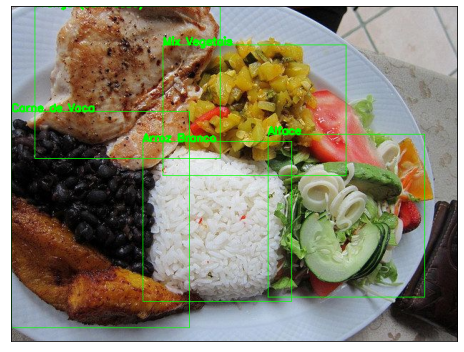

Carne de Vaca: 92.71%
Pure de Batata: 86.57%
Carne de Vaca: 76.41%


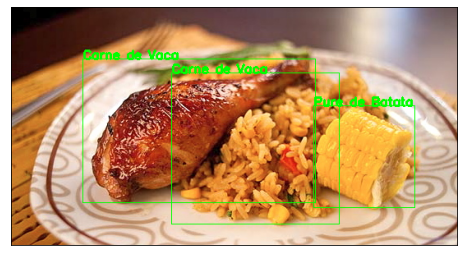

Tomate: 99.59%
Arroz Branco: 99.01%
Alface: 97.22%


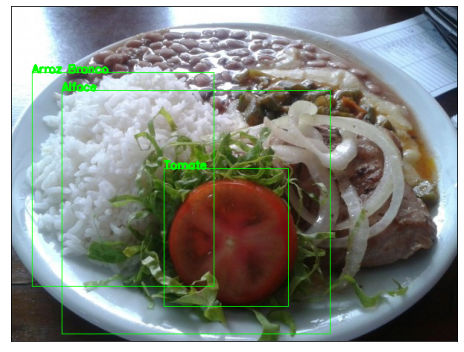

Feijão: 99.86%
Arroz Branco: 97.31%
Cenoura: 97.10%
Frango (sem osso): 95.69%
Carne de Vaca: 89.76%


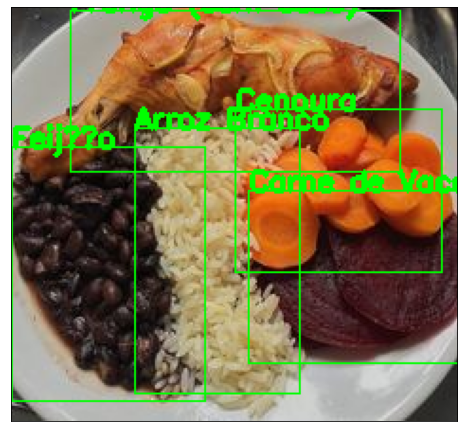

Frango (sem osso): 98.34%
Feijão: 97.82%
Beterraba: 95.62%
Carne de Vaca: 83.72%
Alface: 81.08%
Abobrinha: 76.84%


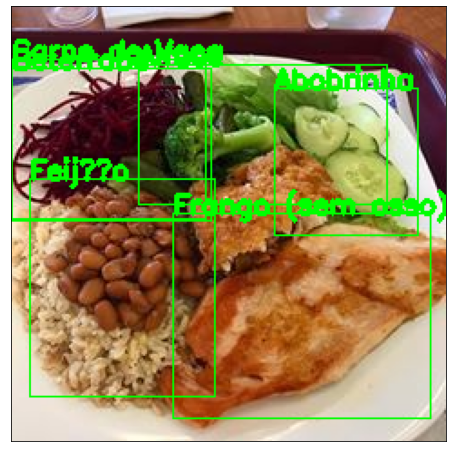

In [ ]:
# validate

start = 300
for idx in range(start,start+5):
  object_detection_api(str(X_train[idx]),codes, modelFasterrcnn, threshold=0.75)

# Predictions

Arroz Branco: 99.46%
Frango (sem osso): 87.76%
Feijão: 86.61%


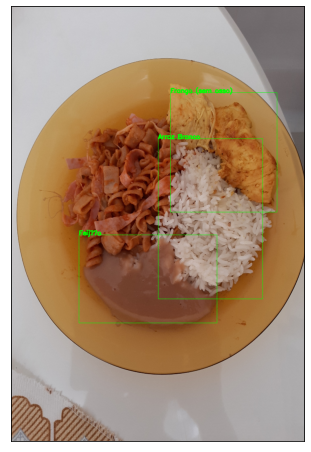

Arroz Branco: 99.87%
Arroz Branco: 97.55%


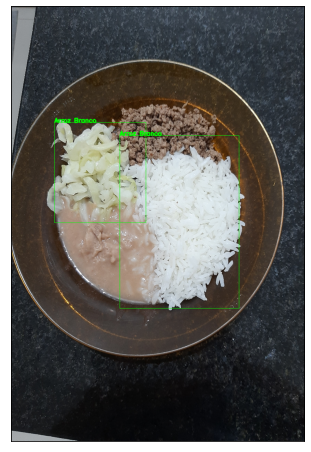

Carne de Vaca: 96.54%
Abóbora: 87.30%
Carne de Vaca: 85.07%


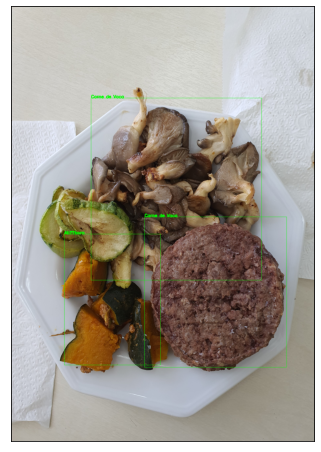

Frango (sem osso): 97.80%
Frango (sem osso): 87.21%
Couve: 85.90%
Carne de Vaca: 81.73%


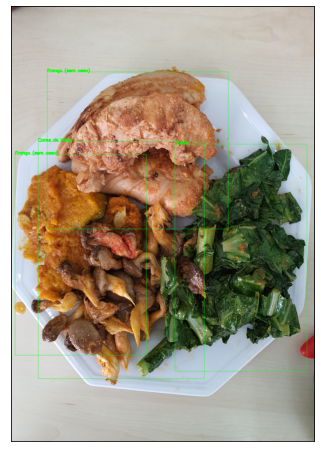

Alface: 99.28%
Arroz Branco: 99.07%
Carne moída: 85.92%


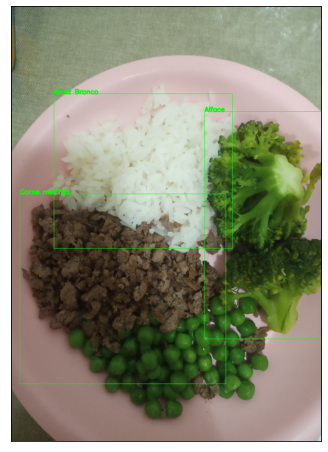

Arroz Branco: 99.46%
Cenoura: 97.61%
Couve: 92.25%
Carne moída: 86.59%


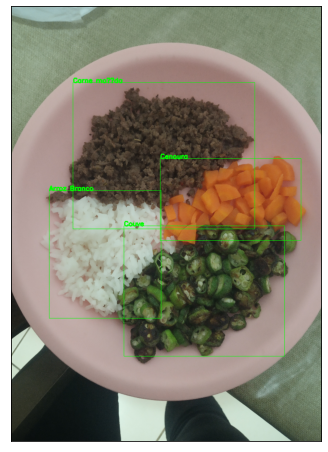

In [ ]:
filepaths = ["./mara1.png","./mara2.png", "joseila1.png","joseila2.png","joseila3.png", "joseila4.png"]

for file in filepaths:
  object_detection_api(file,codes, modelFasterrcnn, threshold=0.75)

# Fastai implementation (SemTorch)


In [ ]:
# SemTorch
from semtorch import get_segmentation_learner

# MaskRCNN Data Utils
from semtorch.models.archs.mask_rcnn import MaskRCNNBlock, IntToFloatTensorMaskRCNN, TfmdDLV2, MaskRCNNDict

# MaskRCNN metrics
from semtorch.utils.metrics import DiceMaskRCNN, JaccardCoeffMaskRCNN

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


## Data Augmentation

In [ ]:
size = (256, 256)
# item_tfms = [Resize(size, method=ResizeMethod.Squish, resamples=(Image.NEAREST,Image.NEAREST))]
item_tfms = [IntToFloatTensorMaskRCNN]
aug_tfms = aug_transforms(mult=1, flip_vert=True, size=size)

## Dataloaders

In [ ]:
# The getters for DataBlock. Returning same image as input and get dict of image as target

foodDetectionOnly = True

def get_label_dict(o):

      mask = get_y_fn(o) # use this when 'adjustedGroundTruthIds' is necessary
      mask = np.array(mask)

      # instances are encoded as different colors
      obj_ids = np.unique(mask)
      # first id is the background, so remove it
      obj_ids = obj_ids[1:]

      # split the color-encoded mask into a set
      # of binary masks
      masks = mask == obj_ids[:, None, None]

      # get bounding box coordinates for each mask
      num_objs = len(obj_ids)
      boxes = []
      for i in range(num_objs):
          pos = np.where(masks[i])
          xmin = np.min(pos[1])
          xmax = np.max(pos[1])
          ymin = np.min(pos[0])
          ymax = np.max(pos[0])
          boxes.append([xmin, ymin, xmax, ymax])

      # convert everything into a torch.Tensor
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      masks = torch.as_tensor(masks, dtype=torch.uint8)
      
      if foodDetectionOnly:
        # there is only one class for food detection
        labels = torch.ones((num_objs,), dtype=torch.int64)
      else:
        labels = torch.as_tensor(obj_ids, dtype=torch.int64)

      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      target["masks"] = masks

      # if self.transforms is not None:
      #     img, target = self.transforms(img, target)

      return target

getters = [lambda o: o, get_label_dict]

In [ ]:
# dataset balance method. choose one of them or none

lossClassWeights = None
sampler = None

#### split by filenames array from pickle ####
import pickle
with open(path + "testFilenames.pkl", 'rb') as f:
  testFiles = pickle.load(f)
X_test = [file for file in fnames if file.name in testFiles]

In [ ]:
bs = 8 # batch size
gradientAcc = int(32/bs) # 32 is the final "batch size"

maskrcnnDataBlock = DataBlock(
    blocks=(ImageBlock, MaskRCNNBlock),
    get_items=get_image_files,
    getters=getters,
    splitter=FuncSplitter(lambda o: o in X_test),
    item_tfms=item_tfms,
    # batch_tfms=aug_tfms,
    dl_type=TfmdDLV2,
    n_inp=1
)

dataloaders = maskrcnnDataBlock.dataloaders(path_img, path=path, bs=bs)
dataloaders.vocab,dataloaders.c = codes,len(codes)

test_dl = dataloaders.test_dl(X_test, with_labels=True)
test_dl.vocab = codes

maskrcnnDataBlock.summary(path_img)


# trainBlock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
#                    get_items=get_image_files,
#                    splitter=FuncSplitter(lambda o: o in X_test),
#                    get_y=get_y_fn,
#                    item_tfms=item_tfms, 
#                    batch_tfms=[*aug_tfms, Normalize.from_stats(*imagenet_stats)])
# dataloaders = trainBlock.dataloaders(path_img, path=path, bs=bs)
# trainBlock.summary(path_img)

Setting-up type transforms pipelines
Found 469 items
2 datasets of sizes 362,107
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: get_label_dict -> MaskRCNNDict.create

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      /content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/231.jpg
    applying <lambda> gives
      /content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/231.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=257x257
  Pipeline: get_label_dict -> MaskRCNNDict.create
    starting from
      /content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/done/231.jpg
    applying get_label_dict gives
      {'boxes': tensor([[116., 104., 256., 220.],
        [ 73.,  14., 246., 130.],
        [  7., 114.,  78., 214.],
        [ 79., 160., 172., 231.],
        [ 50., 112., 133

In [ ]:
len(dataloaders.train_ds), len(dataloaders.valid_ds), len(test_dl.dataset)

(362, 107, 107)

In [ ]:
# dataloaders.train.show_batch(max_n=4, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

In [ ]:
# dataloaders.valid.show_batch(max_n=4, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

In [ ]:
# test_dl.show_batch(max_n=4, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

## Metrics

In [ ]:
from fastaiMetrics import acc_segmentationMaskRCNN, MIOU

# classes_index = range(1, len(codes)) #exclude background class at index 0
# metrics = [acc_segmentation, DiceMulti, MIOU(classes_index, axis=1)]

metrics = [acc_segmentationMaskRCNN, DiceMaskRCNN(), JaccardCoeffMaskRCNN()]

## Model

In [ ]:
#  Definition of the splitter for saying the learner what weights of the network to freeze

def maskrcnn_splitter(model):
    return [params(model.backbone), params(model.rpn), params(model.roi_heads)]

In [ ]:
numClasses = 2 if foodDetectionOnly else len(codes)
modelCallbacks = [ShowGraphCallback]
opt_func = Adam

learner = get_segmentation_learner(dls=dataloaders, number_classes=numClasses, segmentation_type="Semantic Segmentation",
                                 architecture_name="maskrcnn", backbone_name="resnet50", 
                                 image_size=256, metrics=metrics, wd=1e-2,
                                 splitter=maskrcnn_splitter,cbs=modelCallbacks, opt_func=opt_func)


# # EarlyStoppingCallback(monitor='miou',patience=50) -> if patience is too high, this may cause error in learner.validate()
# modelCallbacks = [ShowGraphCallback]
# opt_func = Adam
# learner = unet_learner(dataloaders, resnet34, loss_func=loss_func, opt_func=opt_func, metrics=metrics, cbs=modelCallbacks,
#                        self_attention=False, act_cls=Mish).to_fp32()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
#learner.model[0].load_state_dict(torch.load(path_to_drive + 'DiabetesLearning/trainingConfig/resnet34_encoder-food101.h5'), strict=True); #load preTrained from FOOD101

In [ ]:
# learner.load(path + 'stage-2-brazilFoods', strict=False)
# learner.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# learner.model.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# test = Learner(dataloaders,resnet34)
# learner.load('stage-1-best')

## Training

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=3.630780702224001e-05)

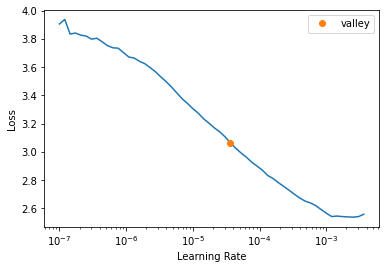

In [ ]:
learner.lr_find()

In [ ]:
def myFineTune(learnerObject, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    
    # Just freezing maskrcnn backbone
    learnerObject.freeze_to(-2)
    learnerObject.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)

    base_lr /= 2
    learnerObject.unfreeze()
    learnerObject.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)


In [ ]:
lr = 1e-4
freezeEpochs = 10
unfreezeEpochs = 20
wd = 1e-2

In [ ]:
run = wandb.init(project="diabetesLearning-instanceSegmentation") # track machine learning experiment
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='dice', fname='stage-1-best',with_opt=True), GradientAccumulation(n_acc=gradientAcc)]
myFineTune(learner, unfreezeEpochs, base_lr=lr, freeze_epochs=freezeEpochs, pct_start=0.3, wd=wd, cbs=fitCallbacks)
run.finish()

## Fine-tunning (optional)

In [ ]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [ ]:
# learner = unet_learner(dataloaders, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=metrics, cbs=callbacks,
#                        wd_bn_bias=True).to_fp16()
# learner.load('stage-1-best')


In [ ]:
learner.unfreeze()
# learner.lr_find()

In [ ]:
lrs = slice(lr/400,lr/4)
epochs = 50
wd = 1e-2

/content/drive/My Drive/Colab Notebooks/DiabetesLearning/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)


Better model found at epoch 0 with acc_segmentation value: 0.5323270559310913.


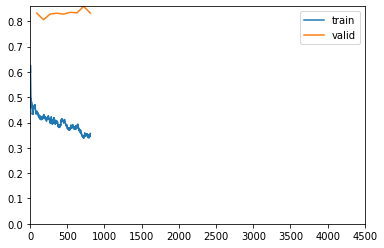

Better model found at epoch 1 with acc_segmentation value: 0.5447819232940674.
No improvement since epoch 1: early stopping


In [ ]:
#run = wandb.init(project="diabetesLearning") # track machine learning experiment
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='acc_segmentation', fname='stage-2-best',with_opt=True),GradientAccumulation(n_acc=gradientAcc)]
# learner.fit_one_cycle(epochs, lrs, pct_start=0.3, wd=wd, cbs=fitCallbacks)
learner.fit_flat_cos(epochs, lrs, wd=wd, cbs=fitCallbacks)
run.finish()

In [ ]:
# learner.load('stage-2-best')
# learner.save('stage-2-size350-bestEpoch')

## FastAI Validation

In [ ]:
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

#### fastai metrics names
metricsNames = ["Loss", "Acc_Segmentation", "Dice", "Miou"]

#### add iou per class if you want
from fastaiMetrics import IOU
iouPerClass = []
for x in range(1,len(codes)): iouPerClass.append(IOU(x, codes[x], axis=1, ignore_index=0)) #ignore background idx 0
learner.metrics = metrics + iouPerClass
metricsNames += ["Iou " + codes[x] for x in range(1,len(codes))]

#### LOAD ONLY IF NECESSARY
# learner = unet_learner(dataloaders, resnet34, metrics=metrics+iouPerClass)
# learner.load('stage-1-best')

In [ ]:
#### check if model overfits ####
trainset = tuple(zip(metricsNames,learner.validate(dl=dataloaders.train)))

#### validate validset ####
validset = tuple(zip(metricsNames,learner.validate(dl=dataloaders.valid)))

"Trainset", trainset, "Validset", validset

('Trainset',
 (('Loss', 0.02755793370306492),
  ('Acc_Segmentation', 0.9537791013717651),
  ('Dice', 0.9573008065624846),
  ('Miou', 0.9422343328130169),
  ('Iou Carbs', 0.9327461677416321),
  ('Iou Proteina', 0.9141959532173162),
  ('Iou Vegetais', 0.9314359032125074),
  ('Iou Frutas', 0.921803159355188)),
 'Validset',
 (('Loss', 0.15403492748737335),
  ('Acc_Segmentation', 0.8400511741638184),
  ('Dice', 0.7950899679457022),
  ('Miou', 0.6651723648813872),
  ('Iou Carbs', 0.7581479285091804),
  ('Iou Proteina', 0.6981870425535122),
  ('Iou Vegetais', 0.7938424216521796),
  ('Iou Frutas', 0.3190084457606669)))

In [ ]:
#### validate testset ####
# learner.dls.valid = test_dl
# testset = tuple(zip(metricsNames,learner.validate(dl=test_dl)))
# "Testset", testset

In [ ]:
dl = dataloaders.valid

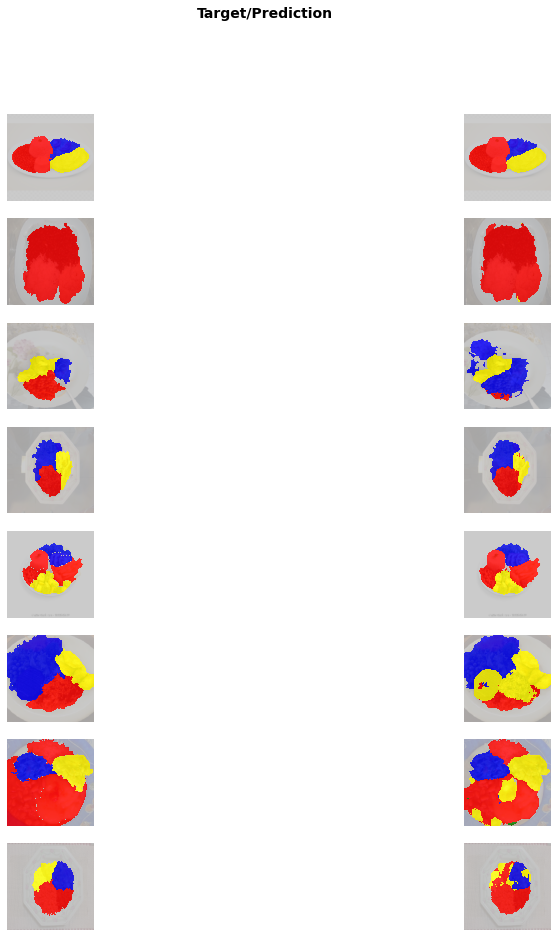

In [ ]:
learner.show_results(dl=dl, figsize=(15,15), max_n=40, cmap=cmap, norm=norm,alpha=0.8)

In [ ]:
# interp = Interpretation.from_learner(learner, dl=test_dl)
# losses,idxs = interp.top_losses()
# interp.plot_top_losses(4, figsize=(15,11), cmap=cmap, norm=norm)

In [ ]:
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#interp.most_confused(min_val=10)

## Sklearn Validation

In [ ]:
from sklearnMetrics import Metrics
void_code = 0
metricsObject = Metrics(codes, [void_code])
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

# LOAD ONLY IF NECESSARY
# learner = unet_learner(dataloaders, resnet34, metrics=metrics)
# learner.load('stage-1-best')

In [ ]:
#input, probabilities, groundTruth, decoded, losses = learner.get_preds(dl=dl,  with_input=True, with_loss=True, with_decoded=True, act=F.softmax) #inputs, preds, groundTruth, losses
input, probabilities, groundTruth, decoded = learner.get_preds(dl=dl,  with_input=True, with_loss=False, with_decoded=True, act=F.softmax) #inputs, preds, groundTruth, losses

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:255: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res[pred_i] = act(res[pred_i])


In [ ]:
print(metricsObject.getAccuracy(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.8394657058144419


In [ ]:
print(metricsObject.get_f1Score(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.8410215281288161


In [ ]:
confusionMatrix = metricsObject.getConfusionMatrix(decoded.flatten().numpy(), groundTruth.flatten().numpy(), plot=False)

In [ ]:
mostConfused = metricsObject.mostConfused(confusionMatrix, numberOfConfusions=4)

print("Actual", "   Predicted", "   Wrong pixels\n")
mostConfused

Actual    Predicted    Wrong pixels



[['Carbs', 'Proteina', 83688],
 ['Proteina', 'Carbs', 68403],
 ['Carbs', 'Vegetais', 54325],
 ['Proteina', 'Vegetais', 28587]]

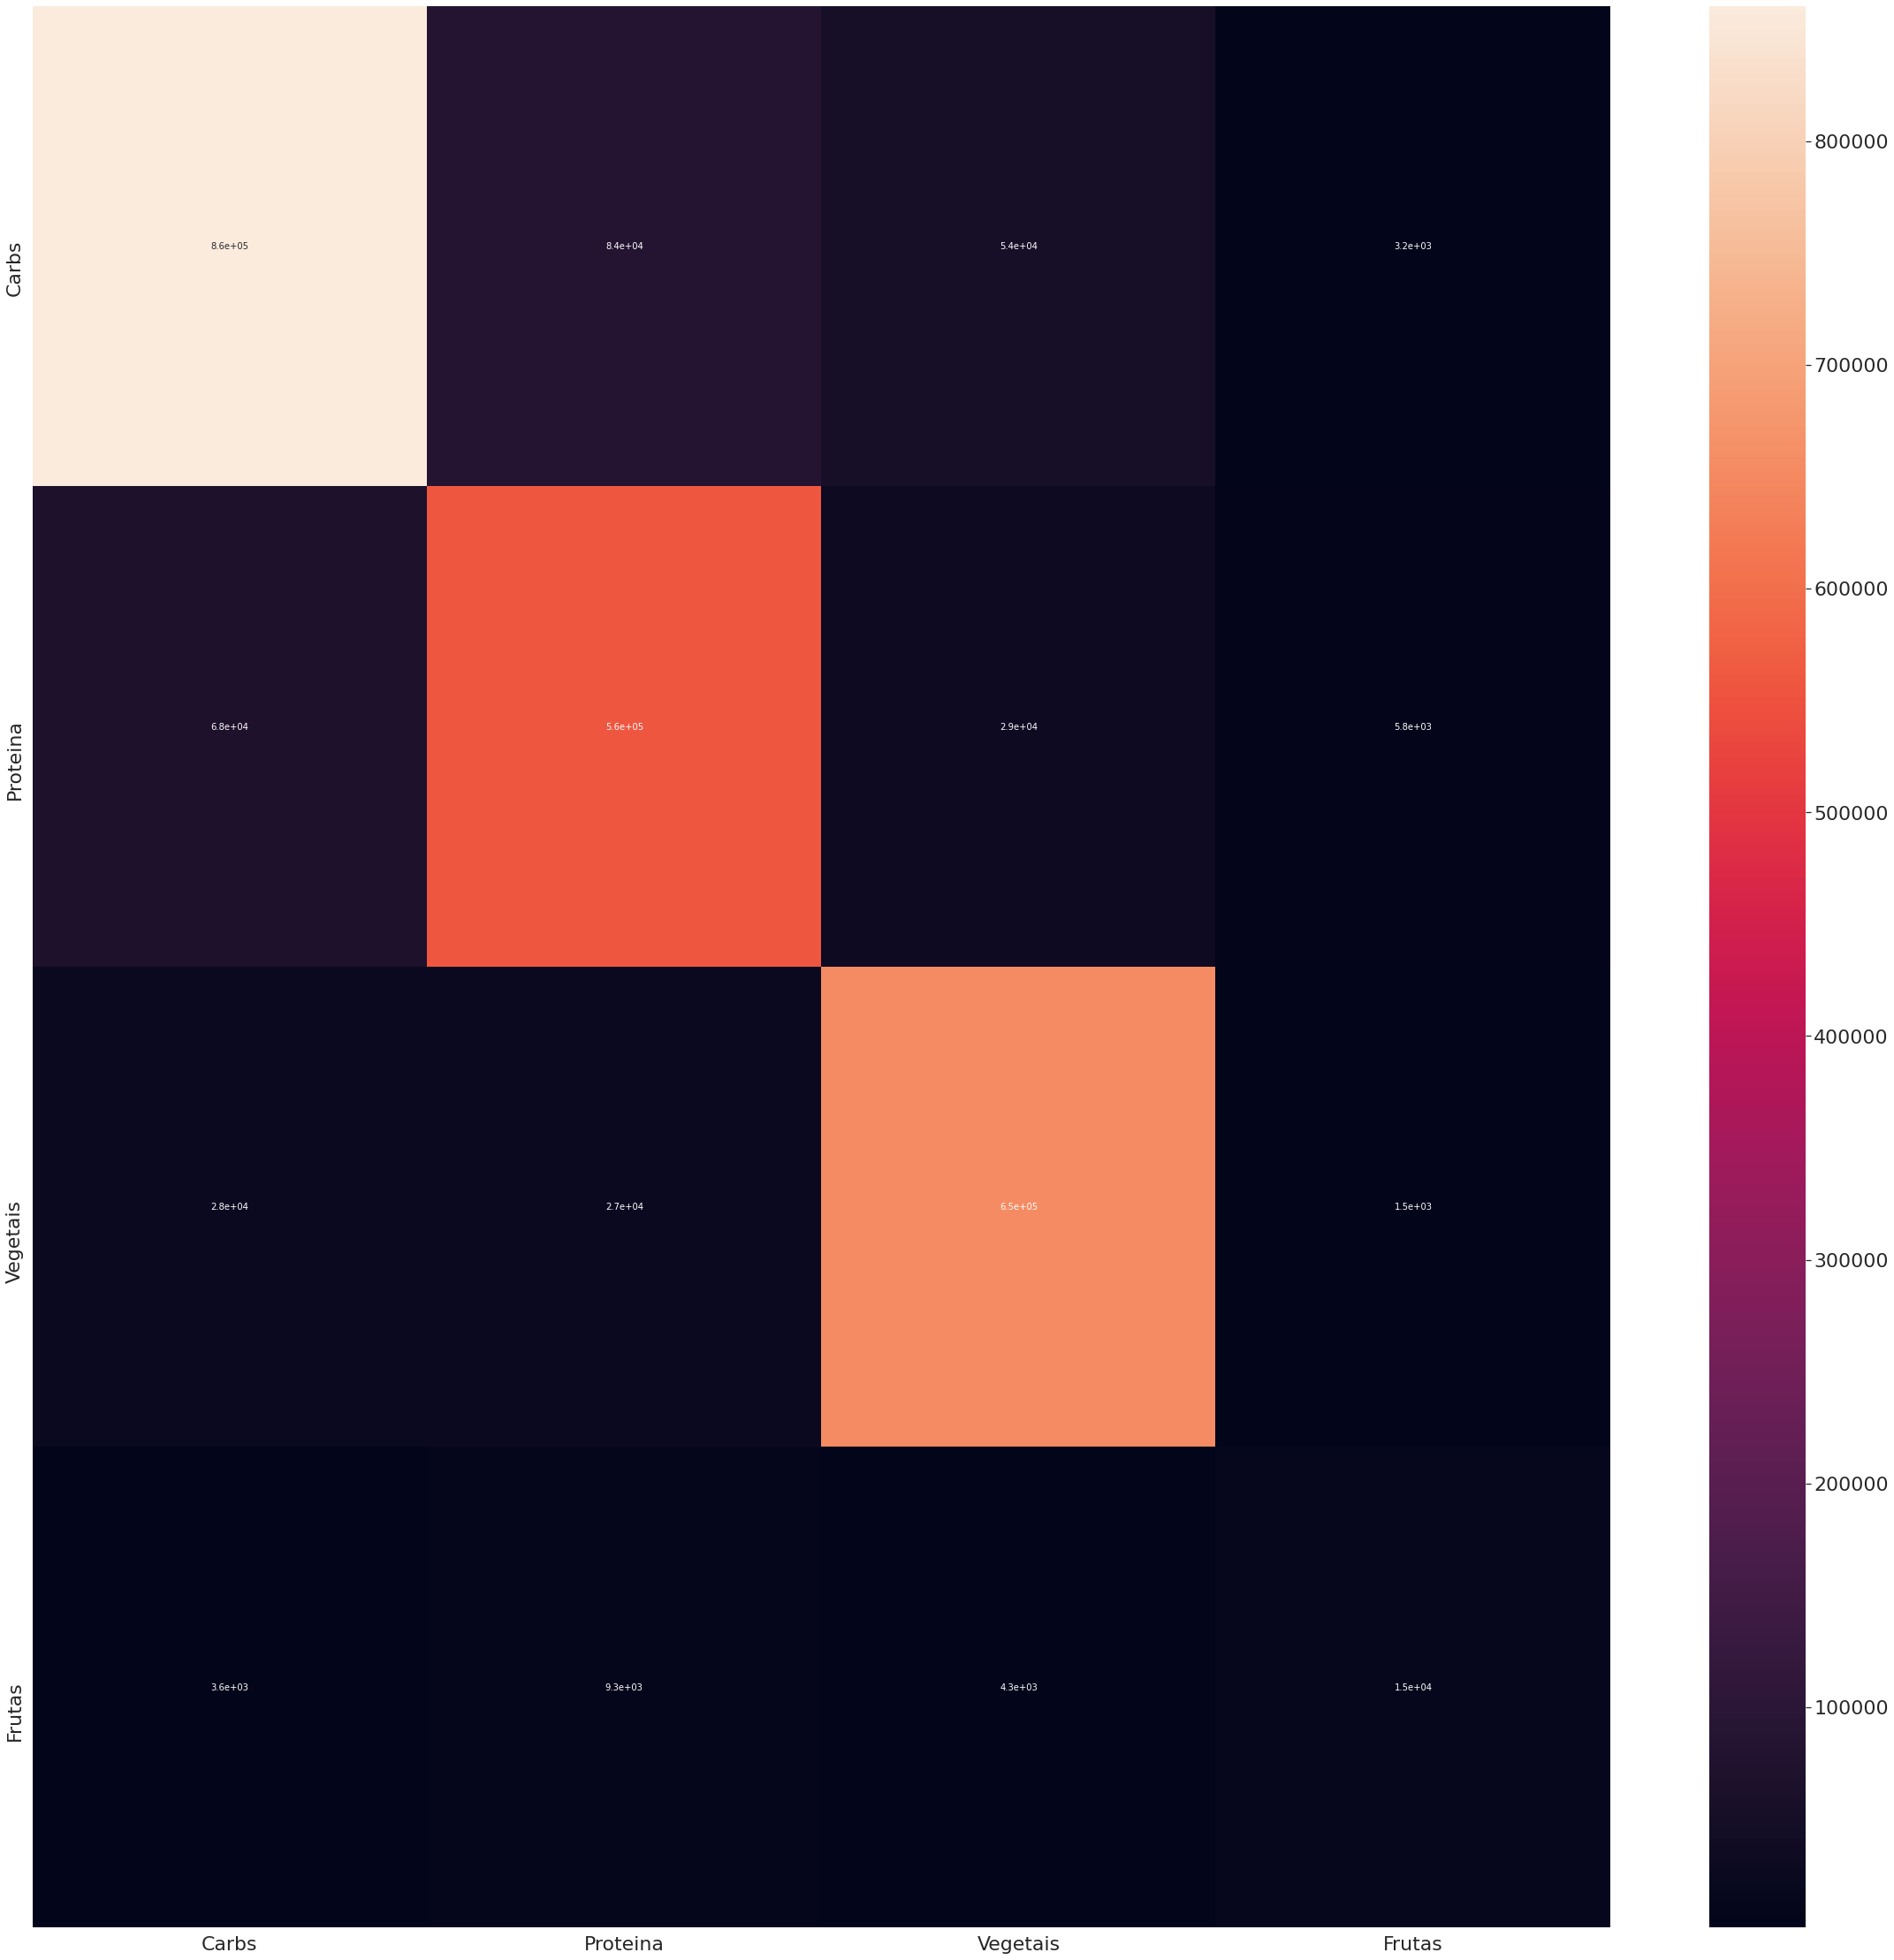

In [ ]:
#plot confusion matrix (take some time, too big the matrix). Think in a better way to visualize (check for most confuseds)

metricsObject.plotConfusionMatrix(confusionMatrix, font_scale=2, removeDiagonal=False)

In [ ]:
print(metricsObject.getClassificationReport(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

              precision    recall  f1-score   support

       Carbs       0.87      0.83      0.85   1035158
    Proteina       0.81      0.82      0.82    676648
    Vegetais       0.85      0.89      0.87    736392
      Frutas       0.53      0.41      0.47     35153

   micro avg       0.84      0.84      0.84   2483351
   macro avg       0.77      0.74      0.75   2483351
weighted avg       0.84      0.84      0.84   2483351



## Check some particular image details

In [ ]:
from collections import OrderedDict

id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

def getFoodsInImage(tensor, removeVoid=False):
    foods, counts = np.unique(tensor,return_counts=True)
    if removeVoid:
        counts = np.delete(counts, 0) #tira o void na posicao 0 do array
        foods = np.delete(foods, 0) #tira o void na posicao 0 do array
    
    foodNames = []
    print(f'Numero de alimentos: {len(foods)}')
    for food in foods:
        foodNames = np.append(foodNames,id2name[food])
    dictCounts = dict(zip(foodNames, counts))
    dictCounts = OrderedDict(sorted(dictCounts.items(), key=lambda x: x[1], reverse=True))
    print(dictCounts)
    return dictCounts

def getMostAppearances(foodCountsDict, k = 3):
    sortedDict = OrderedDict(sorted(foodCountsDict.items(), key=lambda x: x[1], reverse=True))
    topKDict = {}
    for count, (key, v) in enumerate(foodCountsDict.items()):
        if count == k:
            break
        elif key != "NaoAlimento":
            topKDict[key] = v
        else:
            k += 1 # increment k if find NaoAlimento in the first positions
    
    return topKDict
        


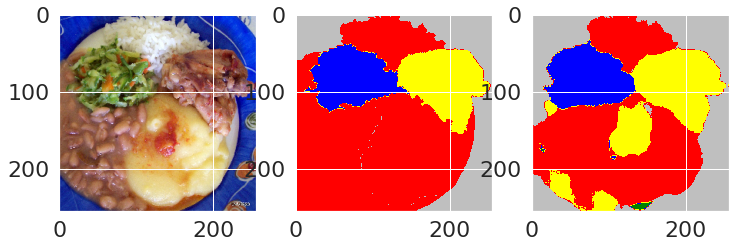

In [ ]:
idx = 6
fig = plt.figure(figsize=(12,12))

# denorm to original image
rawImage = copy(input[idx])

nrm = Normalize.from_stats(*imagenet_stats)
image = nrm.decode(rawImage) #fastai version 2.3.1 needs two denorms!!!! FUCK YOU FASTAI!!!
image = nrm.decode(image).clamp(0,1).squeeze().permute(1,2,0) # denorm image from imagenet stats

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(image)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(groundTruth[idx], cmap=cmap, norm=norm)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(decoded[idx], cmap=cmap, norm=norm)

In [ ]:
print("Ground truth\n")
sample = groundTruth[idx]
gtDictCounts = getFoodsInImage(sample)


Ground truth

Numero de alimentos: 4
OrderedDict([('Carbs', 36171), ('NaoAlimento', 14300), ('Proteina', 8115), ('Vegetais', 6950)])


In [ ]:
print("Prediction\n")
sample = decoded[idx]
decodedDictCounts = getFoodsInImage(sample)


Prediction

Numero de alimentos: 5
OrderedDict([('Carbs', 25732), ('NaoAlimento', 19203), ('Proteina', 13139), ('Vegetais', 7257), ('Frutas', 205)])


In [ ]:
# get low prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)
lowProbs = []
lowProbsIdx = []

mask = bestProbs < 0.5
lowProbsIdx = bestProbsIdx[mask]
lowProbDictCounts = getFoodsInImage(lowProbsIdx)

print("\nPercentual de pixeis com baixa probabilidade\n")
for key, value in lowProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 5
OrderedDict([('Carbs', 15695), ('Proteina', 6658), ('NaoAlimento', 3616), ('Vegetais', 2058), ('Frutas', 205)])

Percentual de pixeis com baixa probabilidade

Carbs 60.99 %
Proteina 50.67 %
NaoAlimento 18.83 %
Vegetais 28.36 %
Frutas 100.00 %


In [ ]:
# get high prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)

mask = bestProbs > 0.5
highProbsIdx = bestProbsIdx[mask]
highProbDictCounts = getFoodsInImage(highProbsIdx)

print("\nPercentual de pixeis com alta probabilidade\n")
for key, value in highProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 5
OrderedDict([('Carbs', 24024), ('NaoAlimento', 18602), ('Proteina', 11822), ('Vegetais', 6995), ('Frutas', 80)])

Percentual de pixeis com alta probabilidade

Carbs 93.36 %
NaoAlimento 96.87 %
Proteina 89.98 %
Vegetais 96.39 %
Frutas 39.02 %


## Predictions of new input data

In [ ]:
# always load it!

learner = unet_learner(dataloaders, resnet34, self_attention=False, act_cls=Mish)
learner.load('stage-1-best')

In [ ]:
#input should be a PIL object

index = 50
img = dataloaders.valid_ds[index][0]

# img_pil = Image.open("3.jpg")
# img = np.asarray(img_pil.resize((400,400)))

pred = learner.predict(img)

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(pred[0],cmap=cmap)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img)

foods = getFoodsInImage(pred[0])
k = 3
mostAppear = list(getMostAppearances(foods, k=k).keys())
print('\n{} principais alimentos:'.format(k),mostAppear)

## REMOVE THIS LATER (TOMAS)

In [ ]:
from sklearn.preprocessing import label_binarize

mask = groundTruth.unsqueeze(dim=1)!=0
gtOneHotEncoded = label_binarize(groundTruth.flatten().numpy(), classes=range(len(codes)))

# groundTruthIgnoringBackground = groundTruth[mask.squeeze()]
# gtOneHotEncoded = label_binarize(groundTruthIgnoringBackground.flatten().numpy(), classes=range(len(codes)))

# probabilitiesIgnoringBackground = probabilities[mask.unsqueeze(dim=1)]
probabilities = probabilities.reshape((-1,16,256*256))
probabilities = probabilities.permute(0,2,1)
probabilities = probabilities.reshape((-1,16))

flatMask = mask.flatten()
# probabilitiesIgnoringBackground = np.array([Tensor(probabilities[i,:]) for i in range(len(flatMask[:100000])) if flatMask[i] == True])
# probabilitiesIgnoringBackground = probabilities[mask.flatten().unsqueeze(dim=1)]

flatMask.shape, probabilities.shape, gtOneHotEncoded.shape

(torch.Size([5636096]), torch.Size([5636096, 16]), (5636096, 16))

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(gtOneHotEncoded.ravel(), probabilities.ravel())
roc_auc = auc(fpr, tpr)

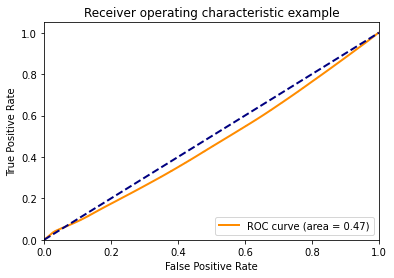

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()